Loading dataset dari file: sample_data/hotel_bookings.xlsx
Dataset shape: (3000, 32)
Data setelah preprocessing shape: (3000, 7)


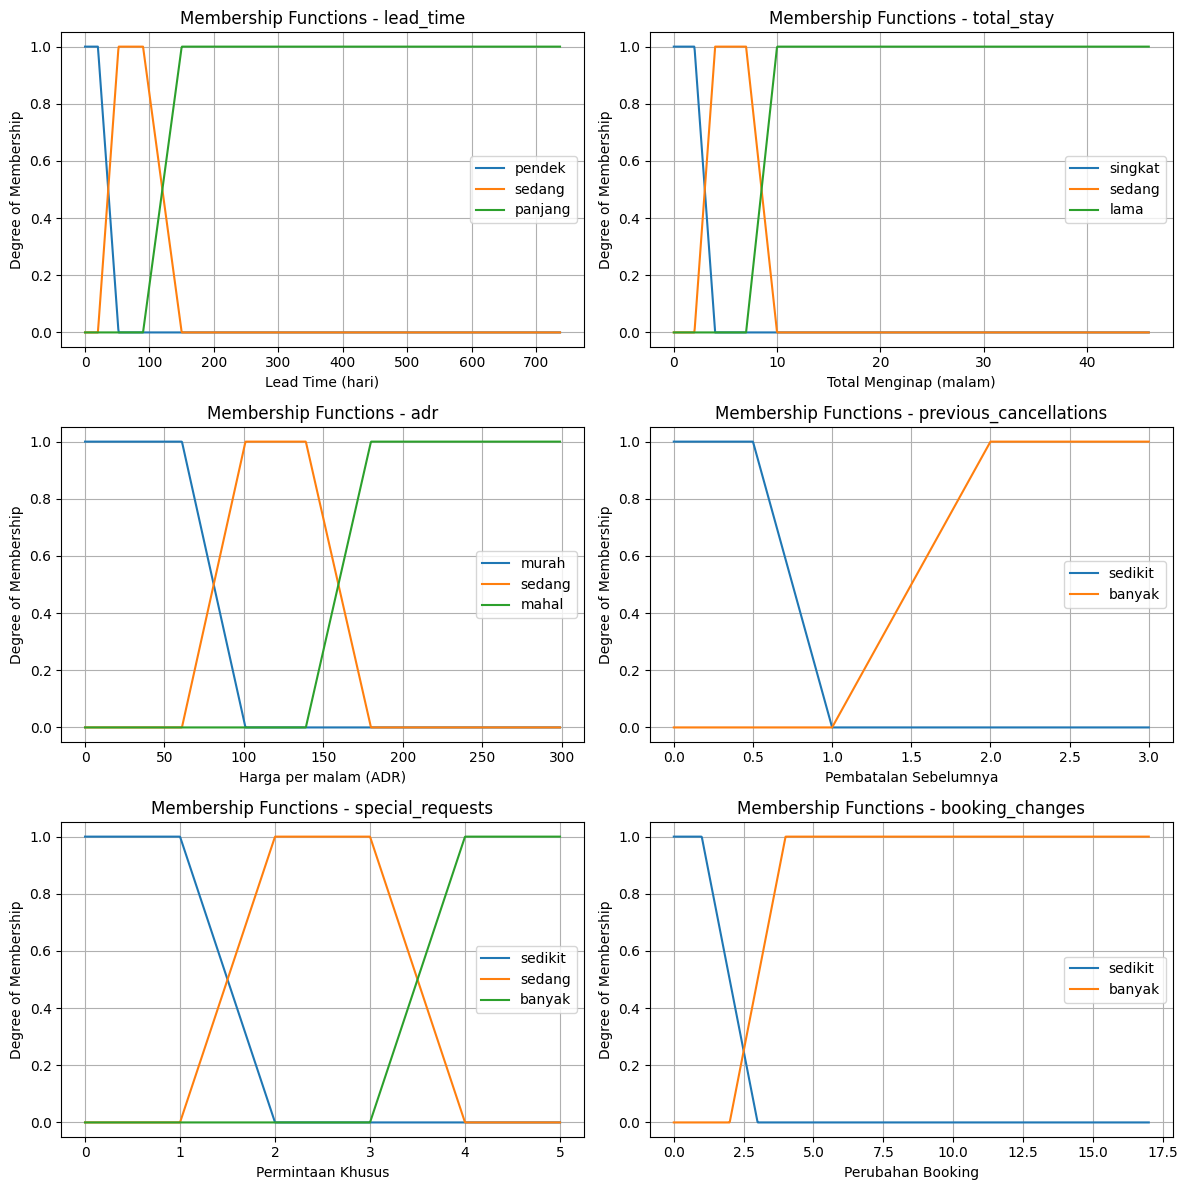


=== Evaluasi Metode Mamdani ===
Akurasi: 0.5243, F1-Score: 0.5975
              precision    recall  f1-score   support

           0       0.40      0.44      0.42      1159
           1       0.62      0.58      0.60      1841

    accuracy                           0.52      3000
   macro avg       0.51      0.51      0.51      3000
weighted avg       0.53      0.52      0.53      3000


=== Evaluasi Metode Sugeno ===
Akurasi: 0.4330, F1-Score: 0.3983
              precision    recall  f1-score   support

           0       0.37      0.64      0.46      1159
           1       0.57      0.31      0.40      1841

    accuracy                           0.43      3000
   macro avg       0.47      0.47      0.43      3000
weighted avg       0.49      0.43      0.42      3000


Contoh prediksi label diskrit:
Data ke-1: Mamdani = tidak puas, Sugeno = tidak puas
Data ke-2: Mamdani = tidak puas, Sugeno = tidak puas
Data ke-3: Mamdani = puas, Sugeno = tidak puas
Data ke-4: Mamdani = puas, S

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, classification_report
import warnings
warnings.filterwarnings('ignore')

class FuzzyHotelSatisfaction:

    def __init__(self):
        # Inisialisasi semua parameter keanggotaa
        self.lead_time_params = {
            'pendek': [0, 0, 20, 52],
            'sedang': [20, 52, 90, 150],
            'panjang': [90, 150, 737, 737]
        }
        self.total_stay_params = {
            'singkat': [0, 0, 2, 4],
            'sedang': [2, 4, 7, 10],
            'lama': [7, 10, 46, 46]
        }
        self.adr_params = {
            'murah': [0, 0, 61, 101],
            'sedang': [61, 101, 139, 180],
            'mahal': [139, 180, 299, 299]
        }
        self.previous_cancellations_params = {
            'sedikit': [0, 0, 0.5, 1],
            'banyak': [1, 2, 3, 3]
        }
        self.special_requests_params = {
            'sedikit': [0, 0, 1, 2],
            'sedang': [1, 2, 3, 4],
            'banyak': [3, 4, 5, 5]
        }
        self.booking_changes_params = {
            'sedikit': [0, 0, 1, 3],
            'banyak': [2, 4, 17, 17]
        }
        self.satisfaction_params = {
            'tidak_puas': [0, 0, 3, 5],
            'puas': [4, 6, 10, 10]
        }

        # ATURAN MAMDANI
        self.rules = [
          ('pendek', 'singkat', 'murah', 'sedikit', 'sedikit', 'sedikit', 'puas'),
          ('pendek', 'sedang', 'murah', 'sedikit', 'sedikit', 'sedikit', 'puas'),
          ('sedang', 'singkat', 'murah', 'sedikit', 'sedikit', 'sedikit', 'puas'),
          ('sedang', 'sedang', 'murah', 'sedikit', 'sedikit', 'sedikit', 'puas'),
          ('sedang', 'sedang', 'sedang', 'sedikit', 'sedikit', 'sedikit', 'puas'),
          ('panjang', 'sedang', 'murah', 'sedikit', 'sedikit', 'sedikit', 'puas'),
          ('panjang', 'lama', 'murah', 'sedikit', 'sedikit', 'sedikit', 'puas'),

          ('pendek', 'singkat', 'mahal', 'banyak', 'banyak', 'banyak', 'tidak_puas'),
          ('panjang', 'lama', 'mahal', 'banyak', 'banyak', 'banyak', 'tidak_puas'),
          ('panjang', 'singkat', 'mahal', 'banyak', 'sedikit', 'sedikit', 'tidak_puas'),
          ('sedang', 'lama', 'mahal', 'banyak', 'banyak', 'sedikit', 'tidak_puas'),
          ('pendek', 'lama', 'mahal', 'banyak', 'banyak', 'banyak', 'tidak_puas'),
        ]


        # ATURAN SUGENO
        self.sugeno_rules = [
            ('pendek', 'singkat', 'mahal', 'banyak', 'banyak', 'banyak', lambda lt, ts, adr, pc, sr, bc: 2),
            ('panjang', 'lama', 'murah', 'sedikit', 'sedikit', 'sedikit', lambda lt, ts, adr, pc, sr, bc: 8),
            ('sedang', 'sedang', 'sedang', 'sedikit', 'sedikit', 'sedikit', lambda lt, ts, adr, pc, sr, bc: 6),
            ('pendek', 'lama', 'mahal', 'sedikit', 'sedikit', 'sedikit', lambda lt, ts, adr, pc, sr, bc: 3),
            ('panjang', 'singkat', 'murah', 'banyak', 'banyak', 'banyak', lambda lt, ts, adr, pc, sr, bc: 2),
            ('panjang', 'lama', 'mahal', 'sedikit', 'sedikit', 'sedikit', lambda lt, ts, adr, pc, sr, bc: 7),
            ('sedang', 'lama', 'sedang', 'sedikit', 'sedikit', 'banyak', lambda lt, ts, adr, pc, sr, bc: 6),
            ('pendek', 'sedang', 'murah', 'banyak', 'banyak', 'sedikit', lambda lt, ts, adr, pc, sr, bc: 3),
        ]

    # Menghitung Derajat Keanggotaan
    def trapezoid_membership(self, x, params):
      a, b, c, d = params
      if a == b:
          left_slope = 1 if x == a else 0
      else:
          left_slope = (x - a) / (b - a) if a < x < b else 0

      if c == d:
          right_slope = 1 if x == d else 0
      else:
          right_slope = (d - x) / (d - c) if c < x < d else 0

      if x < a or x > d:
          return 0 # diluar [a,d]
      elif b <= x <= c:
          return 1 # diantara [b,c]
      elif a <= x < b:
          return left_slope # diantara a -> b
      elif c < x <= d:
          return right_slope # diantara c -> d
      else:
          return 0

    # Mengubah nilai numerik menjadi derajat keanggotaan
    def fuzzify(self, x, params):
        memberships = {}
        for label, p in params.items():
            memberships[label] = self.trapezoid_membership(x, p)
        return memberships

    # Mengumpulkan derajat keanggotaan
    def get_all_memberships(self, inputs):
        return {
            'lead_time': self.fuzzify(inputs['lead_time'], self.lead_time_params),
            'total_stay': self.fuzzify(inputs['total_stay'], self.total_stay_params),
            'adr': self.fuzzify(inputs['adr'], self.adr_params),
            'previous_cancellations': self.fuzzify(inputs['previous_cancellations'], self.previous_cancellations_params),
            'special_requests': self.fuzzify(inputs['special_requests'], self.special_requests_params),
            'booking_changes': self.fuzzify(inputs['booking_changes'], self.booking_changes_params)
        }


    def mamdani_inference(self, inputs):
        # Fuzzification
        memberships = self.get_all_memberships(inputs)

        # Evaluasi berdasar aturan
        rule_results = []
        for rule in self.rules:
            lt_label, ts_label, adr_label, pc_label, sr_label, bc_label, out_label = rule
            strength = min(
                memberships['lead_time'].get(lt_label, 0),
                memberships['total_stay'].get(ts_label, 0),
                memberships['adr'].get(adr_label, 0),
                memberships['previous_cancellations'].get(pc_label, 0),
                memberships['special_requests'].get(sr_label, 0),
                memberships['booking_changes'].get(bc_label, 0)
            )
            if strength > 0:
                rule_results.append((strength, out_label))
        # Agregasi
        aggregated = {}
        for strength, label in rule_results:
            aggregated[label] = max(strength, aggregated.get(label, 0))

        # Defuzzifikasi
        numerator = 0
        denominator = 0
        for label, strength in aggregated.items():
            params = self.satisfaction_params[label]
            centroid = (params[0] + params[1] + params[2] + params[3]) / 4
            numerator += centroid * strength
            denominator += strength

        if denominator == 0:
            return 0
        return numerator / denominator

    def sugeno_inference(self, inputs):
        # Fuzzifikasi
        memberships = self.get_all_memberships(inputs)

        # Evaluasi berdasar aturan
        numerator = 0
        denominator = 0
        for rule in self.sugeno_rules:
            lt_label, ts_label, adr_label, pc_label, sr_label, bc_label, func = rule
            strength = min(
                memberships['lead_time'].get(lt_label, 0),
                memberships['total_stay'].get(ts_label, 0),
                memberships['adr'].get(adr_label, 0),
                memberships['previous_cancellations'].get(pc_label, 0),
                memberships['special_requests'].get(sr_label, 0),
                memberships['booking_changes'].get(bc_label, 0)
            )
            if strength > 0:
                out_value = func(
                    inputs['lead_time'],
                    inputs['total_stay'],
                    inputs['adr'],
                    inputs['previous_cancellations'],
                    inputs['special_requests'],
                    inputs['booking_changes']
                )
                numerator += strength * out_value
                denominator += strength

        if denominator == 0:
            return 0
        return numerator / denominator

# Preproses dataset
def preprocess_hotel_data(df):
    df = df.copy()
    df['total_stay'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']
    for col in ['lead_time', 'adr', 'previous_cancellations', 'total_of_special_requests', 'booking_changes']:
        if col in df.columns:
            df[col] = df[col].fillna(0)
    df['satisfaction_label'] = df.apply(lambda row: 1 if (row['is_canceled'] == 0 and
                                                          row['booking_changes'] <= 1 and
                                                          row['previous_cancellations'] == 0) else 0, axis=1)
    features = ['lead_time', 'total_stay', 'adr', 'previous_cancellations', 'total_of_special_requests', 'booking_changes']
    return df[features + ['satisfaction_label']].copy()

# Menghasilkan skor fuzzy
def predict_batch(model, df, method='mamdani'):
    predictions = []
    for _, row in df.iterrows():
        inputs = {
            'lead_time': row['lead_time'],
            'total_stay': row['total_stay'],
            'adr': row['adr'],
            'previous_cancellations': row['previous_cancellations'],
            'special_requests': row['total_of_special_requests'],
            'booking_changes': row['booking_changes']
        }
        if method == 'mamdani':
            score = model.mamdani_inference(inputs)
        else:
            score = model.sugeno_inference(inputs)
        predictions.append(score)
    return np.array(predictions)

# Mengubah skor fuzzy menjadi prediksi
def evaluate_predictions(y_true, scores, threshold=5):
    y_pred = (scores >= threshold).astype(int)
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    return acc, f1, report

# Menampilkan grafik tiap fungsi ekanggotaan
def plot_membership_functions(model):
    fig, axes = plt.subplots(3, 2, figsize=(12, 12))
    axes = axes.flatten()

    variables = [
        ('lead_time', model.lead_time_params, 'Lead Time (hari)'),
        ('total_stay', model.total_stay_params, 'Total Menginap (malam)'),
        ('adr', model.adr_params, 'Harga per malam (ADR)'),
        ('previous_cancellations', model.previous_cancellations_params, 'Pembatalan Sebelumnya'),
        ('special_requests', model.special_requests_params, 'Permintaan Khusus'),
        ('booking_changes', model.booking_changes_params, 'Perubahan Booking'),
    ]

    for i, (varname, params, xlabel) in enumerate(variables):
        ax = axes[i]
        x_min = min([p[0] for p in params.values()])
        x_max = max([p[-1] for p in params.values()])
        x = np.linspace(x_min, x_max, 1000)
        for label, p in params.items():
            y = [model.trapezoid_membership(xi, p) for xi in x]
            ax.plot(x, y, label=label)
        ax.set_title(f'Membership Functions - {varname}')
        ax.set_xlabel(xlabel)
        ax.set_ylabel('Degree of Membership')
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()

# Mengubah skor fuzzy menjadi list linguistik
def scores_to_labels(scores, threshold=5):
    labels = ['puas' if s >= threshold else 'tidak puas' for s in scores]
    return labels


if __name__ == "__main__":

    input_file = "sample_data/hotel_bookings.xlsx"  # sesuaikan path

    print(f"Loading dataset dari file: {input_file}")
    df_raw = pd.read_excel(input_file)
    print(f"Dataset shape: {df_raw.shape}")

    # Proses data Set
    df = preprocess_hotel_data(df_raw)
    print(f"Data setelah preprocessing shape: {df.shape}")

    model = FuzzyHotelSatisfaction()

    #  Menampilkan grafik
    plot_membership_functions(model)

    # Prediksi Menggunakan Mamdani
    mamdani_scores = predict_batch(model, df, method='mamdani')

    # Prediksi Menggunakan Sugeno
    sugeno_scores = predict_batch(model, df, method='sugeno')

    print("\n=== Evaluasi Metode Mamdani ===")
    acc_m, f1_m, rep_m = evaluate_predictions(df['satisfaction_label'].values, mamdani_scores, threshold=1)
    print(f"Akurasi: {acc_m:.4f}, F1-Score: {f1_m:.4f}")
    print(rep_m)

    print("\n=== Evaluasi Metode Sugeno ===")
    acc_s, f1_s, rep_s = evaluate_predictions(df['satisfaction_label'].values, sugeno_scores, threshold=1)
    print(f"Akurasi: {acc_s:.4f}, F1-Score: {f1_s:.4f}")
    print(rep_s)

    mamdani_labels = scores_to_labels(mamdani_scores, threshold=1)
    sugeno_labels = scores_to_labels(sugeno_scores, threshold=1)

    print("\nContoh prediksi label diskrit:")
    for i in range(1000):
        print(f"Data ke-{i+1}: Mamdani = {mamdani_labels[i]}, Sugeno = {sugeno_labels[i]}")